## n-queens problem


Klasa problemów NP (nondeterministic polynomial time) to klasa problemów, które można rozwiązać w czasie wielomianowym przez niedeterministyczną maszynę Turinga. Innymi słowy, problemy z tej klasy nie mają rozwiązań deterministycznych, które działają w czasie wielomianowym. Z tego powodu ich złożoność jest bardzo wysoka, rzędu 2^n lub (n!), co uniemożliwia ich rozwiązanie w czasie rzeczywistym za pomocą podejść deterministycznych. Problemem NP-zupełnym nazywa się problem, który należy do klasy NP i który może być użyty do rozwiązania każdego innego problemu z klasy NP. Oznacza to, że jeśli istnieje algorytm wielomianowy rozwiązujący problem NP-zupełny, to istnieje również algorytm wielomianowy rozwiązujący każdy inny problem z klasy NP. W przypadku problemów NP-zupełnych, stosowanie metod heurystycznych może być jedyną opcją rozwiązania w czasie rzeczywistym. 
Do metod metaheurystycznych (bardziej zaawansowanych algorytmów przeszukiwania przestrzeni rozwiązań od metod heurystycznych) należą, między innymi, Algorytm Genetyczny - Genetic Algorithm (GA), Algorytm Optymalizacji Rojem Cząstek - Particle Swarm Optimization (PSO) oraz Algorytm Mrówkowy - Ant Colony Optimization (ACO).

N-Queens Problem jest jednym z problemów NP-zupełnych, dla których nie ma szybkich algorytmów rozwiązujących. Polega na rozmieszczeniu n hetmanów na szachownicy o wymiarach nxn tak, aby żadna para nie znajdowała się w tej samej kolumnie, wierszu i przekątnej. Złożoność obliczeniowa tego zagadnienia to co najmniej O(n!), stąd liczba możliwych rozwiązań rośnie bardzo szybko wraz z rozmiarem szachownicy i liczbą hetmanów, którą trzeba umieścić. To sprawia, że ​​problem staje się trudny do rozwiązania dla większych wartości n. Żadne znane mi źródła nie wskazywały, iż odnaleziono wszystkie możliwe rozwiązania dla szachownicy nxn, gdzie n>27.


N-queens dobre ustawienie:

![nqueens dobre ustawienie](2.jpg)

N-queens złe ustawienie:

![nqueens złe ustawienie](1.jpg)


Aby znaleźć dobre ustawienie hetmanów dla plansz z przedziału 5 <= n <= 20 wykorzystuję Algorytm Genetyczny.

Algorytm Genetyczny  to strategia rozwiązywania problemów za pomocą funkcji metaheurystycznej inspirowanej naturą, a dokładniej ewolucją. Wykorzystuje pewne zjawiska biologiczne do znajdowania najlepszego rozwiązania danego problemu.

In [2]:
import pygad
import numpy as np
import time
import math

Rozwiązanie to organizm - chromosom z zestawem genów.
Początkowo, z naiwnym podejściem, zdefiniowałam chromosom jako tablicę tupli - współrzędnych o długości n. Jednakże takie podejście zwiększało czas obliczeń i sprawiało, że pisanie funkcji fitness było trudniejsze. Należy zwrócić uwagę, że dla planszy nxn, każdy hetman powinien zająć miejsce w osobnej kolumnie, czyli być permutacją n miejsc. Zatem wystarczy stworzyć tablicę długości n. W tym chromosomie geny przyjmują wartości od 0 do n, które oznaczają ustawienie odpowiednio w danym rzędzie.

Stąd zapisuję dla N = n:


In [3]:
N = 8

Zakres wartości genów:

In [4]:
gene_space = [{"low": 0, "high": N, "step": 1, }]*N

Liczbę genów oraz ich typ:

In [5]:
num_genes = N
gene_type = int

W wyborze metody selekcji rodziców brałam pod uwagę trzy opcje: “rank”, “rws” i “sss”. Zdecydowałam się pozostać przy steady-state selection, ponieważ wygląda na bardziej efektywny w przypadku, gdy rozwiązanie problemu jest bardzo skomplikowane i ma wiele lokalnych minimów, a przestrzeń rozwiązań jest trudna do przeszukania. W SSS tylko kilka osobników jest zastępowanych na raz, więc znaczna część populacji przetrwa do następnej generacji, co pozwala zachować większą różnorodność w populacji i uniknąć przedwczesnej zbieżności do lokalnego minimum. Rws (roulette wheel selection) i rank selection, mogą szybciej wpadać w pułapki lokalnych minimów i mieć problemy z utrzymaniem różnorodności populacji.

In [6]:
parent_selection_type = "sss"

Dla typu skrzyżowania rozważałam głównie “single point” oraz “two points”.
Single point crossover polega na wylosowaniu jednego punktu przecięcia, gdzie zostają wymienione geny między dwoma rodzicami. Natomiast two points crossover polega na wylosowaniu dwóch punktów przecięcia i wymianie fragmentów genów między rodzicami. Ostatecznie zdecydowałam się na crossover type=“single point”, ponieważ single point crossover ma tendencję do zachowywania sekwencji genów w każdym rodzicu, co jest korzystne w moim problemie, gdzie sekwencja genów jest ważna. Co więcej, single point crossover ma tendencję do zachowywania połowy genów z każdego rodzica, co pomaga w uniknięciu utraty ważnych informacji genetycznych. Ponadto, ma mniejszy koszt czasu obliczeń.

In [7]:
crossover_type = "single_point"

Typ mutacji to “random”, ponieważ losowość mutacji pozwala na eksplorowanie różnych obszarów przestrzeni rozwiązań, co może przeciwdziałać utknięciu w lokalnym minimum.

In [8]:
mutation_type = "random"

Ze względu na wzór oceniania wartości fitness ustalam stop criteria, czyli przerwanie algorytmu dla fitness równego  1.0. Działanie to, pozwala na eliminację zbędnego oczekiwania na przejście wszystkich generacji.

In [9]:
stop_criteria = "reach_1.0"

Procent mutacji genów ustawiam na wartość minimalną, tzn. 1/(dł. chromosomu), ponieważ takie ustawienie dalej  daje dobre wyniki i pozwala zaoszczędzić cenny czas obliczeniowy.

In [10]:
mutation_percent_genes = math.ceil(1/(N)*100)

Następnym krokiem jest ustalenie solutions per population, tzn. rozwiązań dla każdej populacji. Im wyższa wartość tego parametru, tym więcej rozwiązań, niestety rośnie także czas wykonywania obliczeń, dlatego ustalam sol_per_pop na wartość 200 dla inputów małych, 300 dla inputów średnich i 400 dla inputów dużych, dzięki czemu otrzymuje najwięcej rozwiązań w nie najdłuższym czasie.

In [11]:
sol_per_pop = 200

Parametr num_parents_mating jest ustawiony na 15% populacji, co  oznacza że 15% rozwiązań zostanie wybranych jako rodzice do krzyżowania i tworzenia nowych potomków w kolejnej generacji. Umożliwia to zachowanie różnorodności genetycznej w populacji poprzez wybieranie najlepszych osobników, a jednocześnie zapewnia wystarczającą intensywność procesu krzyżowania. W przypadku zbyt niższego procentu wybieranych rodziców, populacja mogłaby szybko utknąć w minimum lokalnym, a w przypadku zbyt wysokiego procentu - mogłoby zabraknąć różnorodności genetycznej, co może prowadzić do zbyt szybkiego zbieżności do suboptymalnego rozwiązania.

In [12]:
num_parents_mating = int(sol_per_pop*0.15)

Liczba rodziców do zatrzymania w populacji (keep parents) to wybór najlepszych rodziców, którzy mają przeżyć do nas†pengo pokolenia. Parametr ustalony jest na 5% liczby rodziców do krzyżowania, co jest kompromisem między eksploracją a eksploatacją przestrzeni przeszukiwań. 

In [13]:
keep_parents = int(num_parents_mating*0.05)

Liczba generacji jest istotna przy większych N, gdy jest potrzebne więcej iteracji na odnalezienie rozwiązania. 500 wydaje się odpowiednią maksymalna wartością oczekiwania na osiągniecie wyniku dla moich największych plansz.

In [14]:
num_generations = 300

Funkcja fitness jest skonstruowana tak, aby liczyć punkty karne za konflikty hetmanów. Dzięki konstrukcji chromosomu, konflikty nie są możliwe w pionie (kolumnach). Natomiast w poziomie, liczę duplikaty - czyli sprawdzam czy pionki nie są ustawione w tym samym rzędzie. Co więcej, tworzę tablicę zer, którą wypełniam jedynkami, tak aby później znaleźć ewentualne powtórzenia po przekątnych tablicy. Jeżeli takie się znajdują również liczę je jako punkty karne. W funkcji fitness premiowane są zawsze chromosomy z najwyższą oceną, dlatego skonstruowałam ocenianie w skali od ułamka bliskiego zeru do 1.0.

In [15]:
def generateChessboard(solution):
    n = len(solution)
    board = np.zeros((n, n))
    
    for col, row in enumerate(solution):
        board[row][col] = 1

    return board

def fitness_function(solution, solution_idx):
    board = generateChessboard(solution)
    # check for duplicates in rows
    num_duplicates = 0
    num_duplicates += len(solution) - len(set(solution))
    # check conflicts in diagonals
    conflicts = 0
    for i in range(-(len(solution)-1), len(solution)):
        diag1 = np.sum(np.diagonal(board, offset=i))
        diag2 = np.sum(np.diagonal(np.fliplr(board), offset=i))
        if diag1 > 1: 
            conflicts += diag1
        if diag2 > 1:
            conflicts += diag2
                    
    return (1.0 / (1.0 + conflicts + num_duplicates))

fitness_func = fitness_function

Time: 0.31 seconds
Time: 0.01 minutes
Parameters of the best solution : [7 1 4 2 0 6 3 5]
Fitness value of the best solution = 1.0
Number of generations passed is 5
.  .  .  .  ♛  .  .  .  
.  ♛  .  .  .  .  .  .  
.  .  .  ♛  .  .  .  .  
.  .  .  .  .  .  ♛  .  
.  .  ♛  .  .  .  .  .  
.  .  .  .  .  .  .  ♛  
.  .  .  .  .  ♛  .  .  
♛  .  .  .  .  .  .  .  


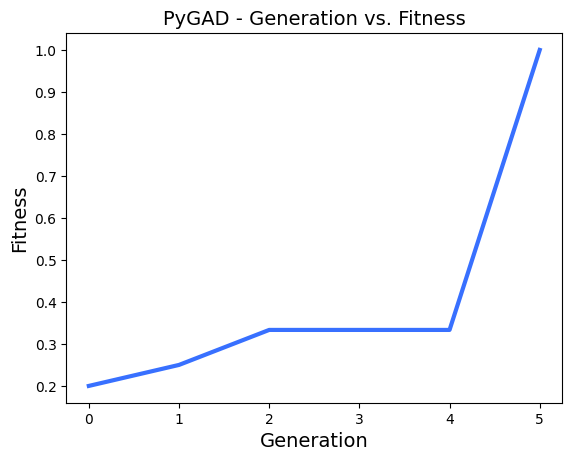

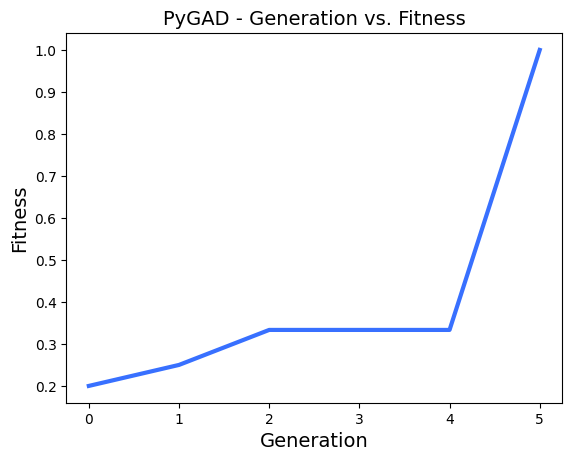

In [16]:
ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       stop_criteria=stop_criteria)

start=time.time()
ga_instance.run()
end=time.time()
delta = end-start
print("Time: {:.2f} seconds".format(delta))
print("Time: {:.2f} minutes".format(delta/60))

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

sol_fit = solution.astype(int)
board = [["  " for i in range(N)] for j in range(N)]

for i in range(len(sol_fit)):
    for j in range(len(sol_fit)):
        if i == sol_fit[j]:
            if (i + j) % 2 == 0:
                board[i][j] = "\033[1;37m♛ \033[0m "
            else:
                board[i][j] = "\033[1;35m♛ \033[0m "
        elif (i + j) % 2 == 0:
            board[i][j] = "\033[1;37m. \033[0m "
        else:
            board[i][j] = "\033[1;35m. \033[0m "
            
for i in range(len(board)):
    print("".join(board[i]))

ga_instance.plot_fitness()

Time: 3.65 seconds
Time: 0.06 minutes
Parameters of the best solution : [ 5  7  0 10  3  1  9 11  8  2  4  6]
Fitness value of the best solution = 1.0
Number of generations passed is 34
.  .  ♛  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  ♛  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  ♛  .  .  
.  .  .  .  ♛  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  ♛  .  
♛  .  .  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  .  ♛  
.  ♛  .  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  ♛  .  .  .  
.  .  .  .  .  .  ♛  .  .  .  .  .  
.  .  .  ♛  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  ♛  .  .  .  .  


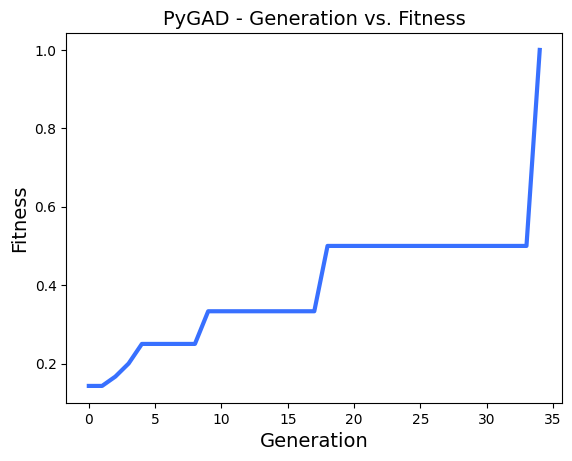

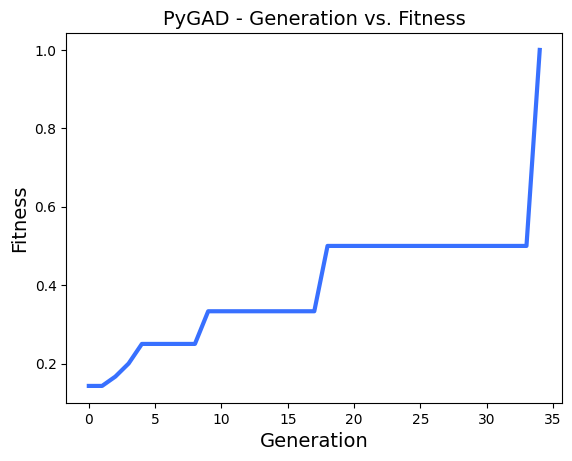

In [30]:
N = 12

gene_space = [{"low": 0, "high": N, "step": 1, }]*N
num_genes = N
mutation_percent_genes = math.ceil(1/(N)*100)
sol_per_pop = 300
num_parents_mating = int(sol_per_pop*0.15)
keep_parents = int(num_parents_mating*0.05)
num_generations = 400

ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       stop_criteria=stop_criteria)

start=time.time()
ga_instance.run()
end=time.time()
delta = end-start
print("Time: {:.2f} seconds".format(delta))
print("Time: {:.2f} minutes".format(delta/60))

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

sol_fit = solution.astype(int)
board = [["  " for i in range(N)] for j in range(N)]

for i in range(len(sol_fit)):
    for j in range(len(sol_fit)):
        if i == sol_fit[j]:
            if (i + j) % 2 == 0:
                board[i][j] = "\033[1;37m♛ \033[0m "
            else:
                board[i][j] = "\033[1;35m♛ \033[0m "
        elif (i + j) % 2 == 0:
            board[i][j] = "\033[1;37m. \033[0m "
        else:
            board[i][j] = "\033[1;35m. \033[0m "
            
for i in range(len(board)):
    print("".join(board[i]))
ga_instance.plot_fitness()

Time: 2.31 seconds
Time: 0.04 minutes
Parameters of the best solution : [10  7  3  1 13  9  6 14 11  4 12  0  8  5  2]
Fitness value of the best solution = 1.0
Number of generations passed is 17
.  .  .  .  .  .  .  .  .  .  .  ♛  .  .  .  
.  .  .  ♛  .  .  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  .  .  .  .  ♛  
.  .  ♛  .  .  .  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  ♛  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  .  .  .  ♛  .  
.  .  .  .  .  .  ♛  .  .  .  .  .  .  .  .  
.  ♛  .  .  .  .  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  .  .  ♛  .  .  
.  .  .  .  .  ♛  .  .  .  .  .  .  .  .  .  
♛  .  .  .  .  .  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  ♛  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  ♛  .  .  .  .  
.  .  .  .  ♛  .  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  ♛  .  .  .  .  .  .  .  


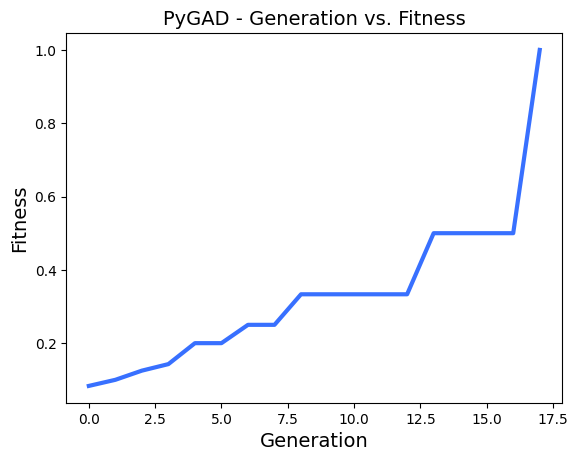

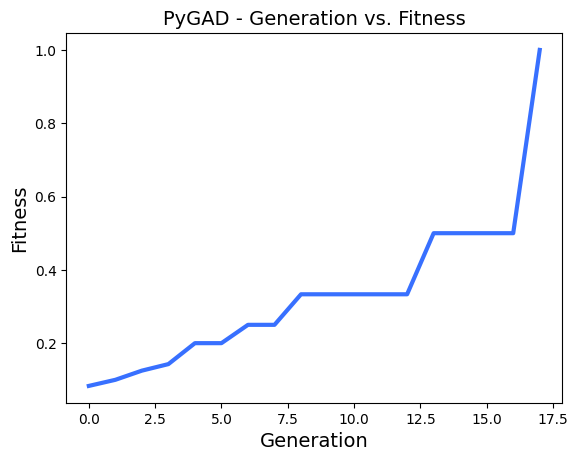

In [31]:
N = 15

gene_space = [{"low": 0, "high": N, "step": 1, }]*N
num_genes = N
mutation_percent_genes = math.ceil(1/(N)*100)
sol_per_pop = 300
num_parents_mating = int(sol_per_pop*0.15)
keep_parents = int(num_parents_mating*0.05)
num_generations = 400

ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       stop_criteria=stop_criteria)

start=time.time()
ga_instance.run()
end=time.time()
delta = end-start
print("Time: {:.2f} seconds".format(delta))
print("Time: {:.2f} minutes".format(delta/60))

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

sol_fit = solution.astype(int)
board = [["  " for i in range(N)] for j in range(N)]

for i in range(len(sol_fit)):
    for j in range(len(sol_fit)):
        if i == sol_fit[j]:
            if (i + j) % 2 == 0:
                board[i][j] = "\033[1;37m♛ \033[0m "
            else:
                board[i][j] = "\033[1;35m♛ \033[0m "
        elif (i + j) % 2 == 0:
            board[i][j] = "\033[1;37m. \033[0m "
        else:
            board[i][j] = "\033[1;35m. \033[0m "
            
for i in range(len(board)):
    print("".join(board[i]))
ga_instance.plot_fitness()

Time: 8.65 seconds
Time: 0.14 minutes
Parameters of the best solution : [17  7 12 19 11  1 15  6  3  0 14  8  4 13 16 18  2 10  5  9]
Fitness value of the best solution = 1.0
Number of generations passed is 42
.  .  .  .  .  .  .  .  .  ♛  .  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  ♛  .  .  .  .  .  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  ♛  .  .  .  
.  .  .  .  .  .  .  .  ♛  .  .  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  .  .  ♛  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  ♛  .  
.  .  .  .  .  .  .  ♛  .  .  .  .  .  .  .  .  .  .  .  .  
.  ♛  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  .  ♛  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  ♛  
.  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  ♛  .  .  
.  .  .  .  ♛  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  
.  .  ♛  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .

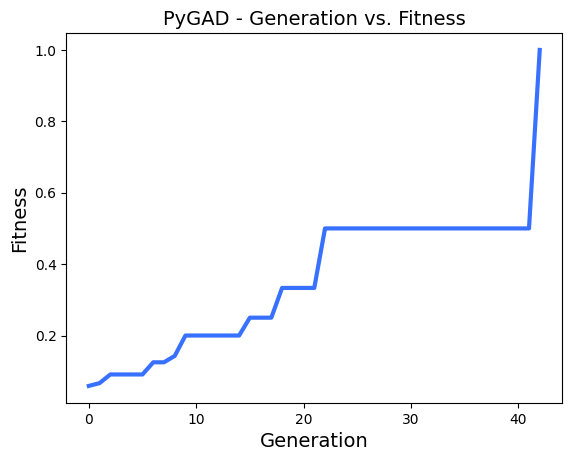

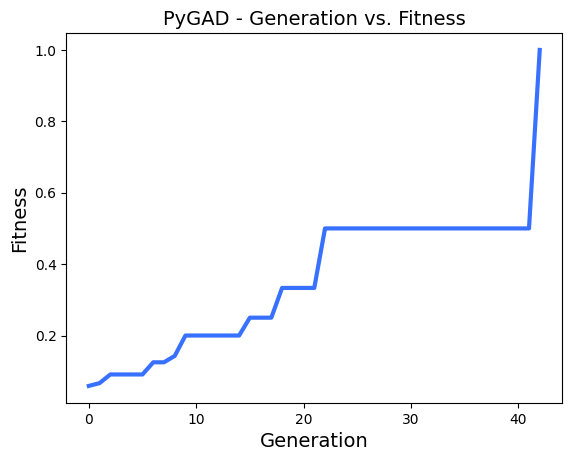

In [32]:

N = 20

gene_space = [{"low": 0, "high": N, "step": 1, }]*N
num_genes = N
mutation_percent_genes = math.ceil(1/(N)*100)
sol_per_pop = 400
num_parents_mating = int(sol_per_pop*0.15)
keep_parents = int(num_parents_mating*0.05)
num_generations = 500

ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       stop_criteria=stop_criteria)

start=time.time()
ga_instance.run()
end=time.time()
delta = end-start
print("Time: {:.2f} seconds".format(delta))
print("Time: {:.2f} minutes".format(delta/60))

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

sol_fit = solution.astype(int)
board = [["  " for i in range(N)] for j in range(N)]

for i in range(len(sol_fit)):
    for j in range(len(sol_fit)):
        if i == sol_fit[j]:
            if (i + j) % 2 == 0:
                board[i][j] = "\033[1;37m♛ \033[0m "
            else:
                board[i][j] = "\033[1;35m♛ \033[0m "
        elif (i + j) % 2 == 0:
            board[i][j] = "\033[1;37m. \033[0m "
        else:
            board[i][j] = "\033[1;35m. \033[0m "
            
for i in range(len(board)):
    print("".join(board[i]))

ga_instance.plot_fitness()

Poniżej przedstawiam zestawienie wszystkich danych wyjściowych i ich średnich wyników. Przedział N <5; 9> uważam za inputy małe, <10; 14> inputy średnie, a <15; 20> inputy duże.

| N | Success Rate | Mean Time | Mean Generations | Example Solution |
|:-:|:------------:|:---------:|:---------------:|:----------------:|
| 5 |    100%      |  0.05 s   |        1        |   [2 0 3 1 4]    |
| 6 |    100%      |  0.57 s   |        20       |   [1 3 5 0 2 4]  |
| 7 |     95%      |  0.24 s   |        6        | [4 2 0 5 3 1 6]  |
| 8 |     99%      |  0.72 s   |        19       | [5 2 6 1 3 7 0 4]|
| 9 |     95%      |  1.34 s   |        31       |[2 4 1 7 0 3 6 8 5]|
| 10|     93%      |  3.55 s   |        51       |[3 0 4 7 9 2 6 8 1 5]|
| 11|     93%      |  3.98 s   |        53       |[5 2 8 3 0 7 10 1 6 4 9]|
| 12|     96%      |  4.02 s   |        50       |[4 8 3 11 2 7 1 10 0 6 9 5]|
| 13|     93%      |  6.79 s   |        77       |[9 2 12 8 3 0 4 1 11 6 10 7 5]|
| 14|     92%      |  6.0 s    |        69       |[2 6 12 7 5 11 13 4 0 8 10 1 3 9]|
| 15|     98%      |  8.03 s   |        86       |[6 12 5 7 11 3 14 2 8 10 1 13 0 9 4]|
| 16|     96%      | 12.28 s   |        86       |[7 0 12 3 13 10 4 11 1 15 2 5 8 14 9 6]|
| 17|    100%      | 12.44 s   |        82       |[2 7 14 8 13 9 0 3 16 12 5 1 10 6 11 15 4]|
| 18|     99%      | 15.71 s   |        101      |[8 4 14 1 5 15 11 3 7 16 12 17 0 13 9 6 2 10]|
| 19|     96%      | 16.55 s   |        98       |[1 5 8 11 15 12 16 2 10 3 13 4 9 18 6 14 0 17 7]|
| 20|     94%      | 17.18 s   |        98       |[9 16 19 10 12 5 1 13 7 2 4 14 0 18 15 17 3 6 8 11]|



Wykres zmiany czasu wykonywania aglorytmu w zależności od wielkości N.

![zmiana wykonywania czasu alglrytmu w zaleznosci od n](n-time.png)

Czas wzrasta stopniowo wraz z zwiększającym się N.

Zmiana liczby generacji, przy której znajdywane jest rozwiązanie, w zależności od wielkości N.

![zmiana liczby generacji w zaleznosci od n](n-generations.png)

Liczba generacji przy której jest znajdywane rozwiązanie również wzrasta.

Algorytm genetyczny jest skutecznym narzędziem do rozwiązywania problemu n-queens.
Dzięki losowemu przeszukiwaniu przestrzeni rozwiązań, algorytm wybiera pewną liczbę rozwiązań początkowych,
a następnie iteracyjnie modyfikuje je i wybiera najlepsze z nich. Dzięki temu, algorytm z dużą skutecznością
znajduje rozwiązania optymalne lub bliskie optymalnym w krótkim czasie.
Należy jednak zwrócić uwagę na ograniczenia algorytmu genetycznego, który czasami może zatrzymać się na minimum lokalnym,
gdzie jeden pionek nie może znaleźć swojego miejsca.
Jednakże, nawet z tym ograniczeniem, algorytm genetyczny pozostaje dobrym wyborem dla problemu n-queens.
Jest w stanie znaleźć rozwiązanie z prawdopodobieństwem powyżej 90% w krótkim czasie, co czyni go świetnym narzędziem do szukania rozwiązań na planszach o różnych wielkościach.

Algorytm Optymalizacji Rojem Cząstek - Particle Swarm Optimization (PSO) to metoda optymalizacji, która jest inspirowana zachowaniem roju zwierząt, takich jak np. ptaki czy ryby. PSO polega na iteracyjnym przeszukiwaniu przestrzeni rozwiązań poprzez manipulację pozycją oraz prędkością cząstek w roju. Każda cząstka reprezentuje jedno rozwiązanie, a rój składa się z wielu cząstek. Celem PSO jest znalezienie najlepszego rozwiązania, czyli takiego, które minimalizuje (lub maksymalizuje) funkcję celu.
Algorytm PSO składa się z trzech głównych etapów: inicjalizacji, aktualizacji położenia i prędkości cząstek oraz aktualizacji najlepszych pozycji. W trakcie iteracji cząstki poruszają się w kierunku najlepszego dotychczas znalezionego rozwiązania.

Jako metoda metaheurystyczna  jest w stanie przeszukiwać przestrzeń rozwiązań w celu znalezienia optymalnego rozwiązania. W problemie N-Queens, przestrzenią rozwiązań jest możliwe rozmieszczenie N hetmanów na szachownicy o wymiarach NxN.

W podejściu PSO, każda cząstka reprezentuje jedno możliwe rozmieszczenie N hetmanów na szachownicy, a pozycja cząstki odpowiada ułożeniu hetmanów. Prędkość cząstki jest modyfikowana na podstawie najlepszego rozwiązania znalezionego przez rój w postaci najlepszego ułożenia hetmanów na szachownicy.
W trakcie iteracji, cząstki zmieniają swoje położenia na szachownicy w kierunku najlepszego rozwiązania, w celu znalezienia coraz lepszych ułożeń hetmanów. Ostatecznie, najlepsze rozwiązanie znalezione przez rój składa się z ułożenia hetmanów, które nie szachują się nawzajem.

Do odnalezienia rozwiązania na szachownicy, wykorzystuję bibliotekę pyswarms.

In [6]:
import pyswarms as ps
from matplotlib import pyplot as plt

Korzystając z tej biblioteki, określam granice wymiarów dla hetmanów:
- x_max to wartość górna, której pozycja hetmana nie może przekroczyć
- x_min to wartość dolna, czyli indeks 0

Obie granice ustawiam w parametrze my bounds, czyli granicy przestrzeni poszukiwań (granice dla każdej współrzędnej).


In [3]:
N = 5 # The number of queens

# Set bounds for each dimension (queen position)
x_max = np.array([N for _ in range(N)])
x_min = np.array([0 for _ in range(N)])
my_bounds = (x_min, x_max)


Fitness_function: funkcja obliczająca wartość funkcji dopasowania (fitness) dla danego ustawienia hetmanów na szachownicy, funkcja musi kowertować liczby typu float na typ int, aby móc przypisać pozycje szachownicy, ocenianie wygląda trochę inaczej niż w algorytmie genetycznym - sumuje punkty karne

Objective_function: funkcja celu, która jest minimalizowana przez algorytm PSO, przyjmuje kandydujące rozwiązanie jako wejście i zwraca wartość skalarną, która reprezentuje to, jak dobrze rozwiązanie spełnia pożądane kryteria

In [4]:
def fitness_function(positions):
    # count the number of non-unique positions (row conflicts)
    positions = [int(x) for x in positions]
    num_duplicates = len(positions) - len(set(positions))
    
    board = np.zeros((len(positions), len(positions)))
    for col, row in enumerate(positions):
        board[int(row)][int(col)] = 1

    # check conflicts in diagonals
    conflicts = 0
    for i in range(-(N-1), N):
        sum1 = np.sum(np.diagonal(board, offset=i))
        sum2 = np.sum(np.diagonal(np.fliplr(board), offset=i))
        if sum1 > 1: 
            conflicts += sum1 - 1
        if sum2 > 1:
            conflicts += sum2 - 1
            
    fitness = num_duplicates + conflicts
    
    return fitness

# objective function to be minimized
def objective_function(positions):
    return np.array([fitness_function(p) for p in positions])

W kodzie jest zdefiniowany słownik options zawierający trzy klucze:
- c1: Parametr kognitywny (cognitive parameter) określa wpływ najlepszej pozycji znalezionej przez daną cząstkę na jej ruch. 
Wartość tego parametru wpływa na szybkość zbiegania do najlepszego rozwiązania przez indywidualną cząstkę. Według źródeł rekomendowaną wartością dla c1 jest przedział <1.5;2>. Decyduję się na wartość 2, ponieważ zależy mi właściwościach poznawczych.
- c2: Parametr społeczny (social parameter) określa wpływ najlepszej pozycji znalezionej wśród wszystkich cząstek na ruch każdej cząstki. Wartość tego parametru wpływa na zdolność całego roju do eksploracji przestrzeni rozwiązań. Według źródeł rekomendowaną wartością dla c2 jest przedział <2; 2.5>. Ustawiam ją na wartość 2, aby wartości c1 i c2 były dobrze wyważone i cząsteczki mogły równomiernie eksplorować i eksploatować obszar poszukiwań rozwiązania.
- w: Parametr bezwładności (inertia parameter) określa wpływ poprzedniej prędkości cząstki na jej ruch.
Wartość tego parametru wpływa na zdolność roju do przeszukiwania obszarów przestrzeni rozwiązań i zapobiega zbyt szybkiemu zbieżeniu do optimum lokalnego.
W tym przykładzie wynosi on 0.5, co równoważy wpływ poprzedniej prędkości i losowości, co może pomóc w znalezieniu najlepszego rozwiązania.

Dobieranie optymalnych parametrów w algorytmie PSO jest procesem skomplikowanym i wymaga eksperymentowania z różnymi konfiguracjami,
a także analizowania wyników i podejmowania decyzji na podstawie osiągniętej wydajności i zbieżności algorytmu.
Wartości parametrów należy dobrać eksperymentalnie, poprzez iteracyjne testowanie różnych wartości i wybieranie tych, które zapewniają najlepsze wyniki.
Pomimo prób wielu wariantów, wyniki były zbliżone.

optimizer: obiekt klasy GlobalBestPSO, który jest odpowiedzialny za przeprowadzenie optymalizacji przy użyciu algorytmu PSO
- n_particles: liczba cząstek, które są tworzone w roju w celu przeszukiwania przestrzeni rozwiązań
- dimensions: liczba wymiarów przestrzeni rozwiązań (w tym przypadku liczba hetmanów)
- iters: liczba iteracji, które będą wykonywane przez algorytm PSO

Zwiększenie liczby cząstek i iteracji w algorytmie PSO może prowadzić do uzyskania lepszych wyników.
Większa liczba cząstek może pozwolić na lepsze pokrycie przestrzeni poszukiwań, co z kolei zwiększa szanse na znalezienie optymalnego rozwiązania. Jednak zbyt duża liczba cząstek może wpłynąć na wydajność algorytmu, co z kolei może negatywnie wpłynąć na czas obliczeń.
Zwiększenie liczby iteracji może pozwolić algorytmowi na dalsze poszukiwania w przestrzeni rozwiązań i zwiększyć szansę na znalezienie optymalnego rozwiązania. Jednak zbyt duża liczba iteracji może prowadzić do przeuczenia algorytmu lub zwiększenia czasu obliczeń.

Wynik przedstawiony jest za pomocą:
- best_cost: najlepsza wartość funkcji celu znaleziona przez algorytm PSO
- best_position: najlepsze rozwiązanie (ustawienie hetmanów na szachownicy) znalezione przez algorytm PSO
- cost_history: historia wartości funkcji celu w kolejnych iteracjach algorytmu PSO

2023-04-01 20:24:50,564 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0
2023-04-01 20:24:50,736 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [3.23479528 0.50315716 2.22827304 4.01003655 1.24513335]


Time: 0.17 seconds
Time: 0.00 minutes
Best solution:  [3.23479528 0.50315716 2.22827304 4.01003655 1.24513335]
[3, 0, 2, 4, 1]
Best fitness:  0


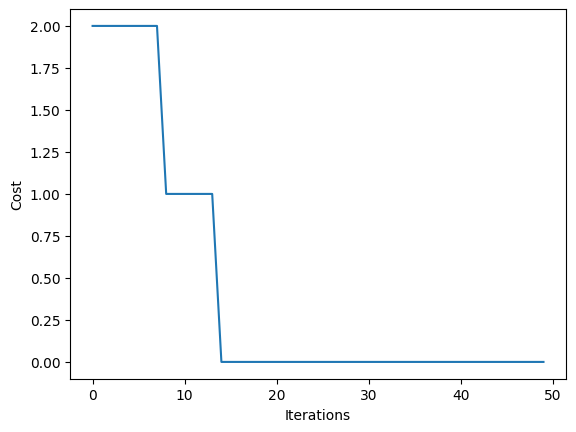

In [36]:
N = 5 # The number of queens

# Set bounds for each dimension (queen position)
x_max = np.array([N for _ in range(N)])
x_min = np.array([0 for _ in range(N)])
my_bounds = (x_min, x_max)

# Define PSO parameters
options = {'c1': 2, 'c2': 2, 'w': 0.5}
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=N, options=options, bounds=my_bounds)

# Optimize the objective function
start=time.time()
best_cost, best_position = optimizer.optimize(objective_function, iters=50)
end=time.time()
delta = end-start
print("Time: {:.2f} seconds".format(delta))
print("Time: {:.2f} minutes".format(delta/60))

# Print the best solution found
print("Best solution: ", best_position)
print([int(x) for x in best_position])
print("Best fitness: ", 0 if best_cost == 0 else best_cost)


# Plot the cost history
plt.plot(optimizer.cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

2023-04-01 20:24:50,974 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=0
2023-04-01 20:24:54,021 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [3.69175763 0.71274621 4.71386205 1.14153578 5.79522224 2.38870047]


Time: 3.05 seconds
Time: 0.05 minutes
Best solution:  [3.69175763 0.71274621 4.71386205 1.14153578 5.79522224 2.38870047]
[3, 0, 4, 1, 5, 2]
Best fitness:  0


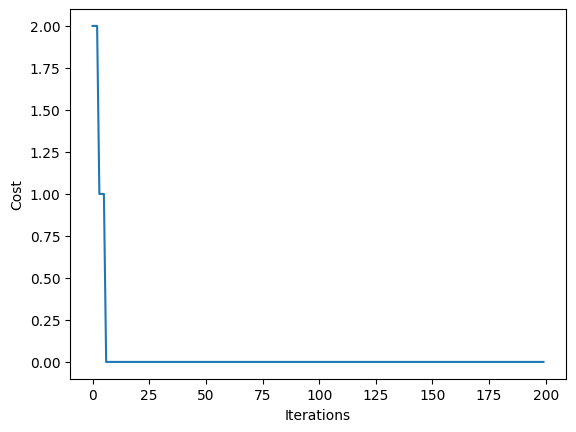

In [37]:
N = 6 # The number of queens

# Set bounds for each dimension (queen position)
x_max = np.array([N for _ in range(N)])
x_min = np.array([0 for _ in range(N)])
my_bounds = (x_min, x_max)

# Define PSO parameters
options = {'c1': 2, 'c2': 2, 'w': 0.5}
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=N, options=options, bounds=my_bounds)

# Optimize the objective function
start=time.time()
best_cost, best_position = optimizer.optimize(objective_function, iters=200)
end=time.time()
delta = end-start
print("Time: {:.2f} seconds".format(delta))
print("Time: {:.2f} minutes".format(delta/60))

# Print the best solution found
print("Best solution: ", best_position)
print([int(x) for x in best_position])
print("Best fitness: ", 0 if best_cost == 0 else best_cost)

# Plot the cost history
plt.plot(optimizer.cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()


2023-04-01 20:24:54,217 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=0
2023-04-01 20:24:57,674 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [6.02997738 2.29480014 5.8823372  1.81265119 4.2110493  0.32922637
 3.64905974]


Time: 3.46 seconds
Time: 0.06 minutes
Best solution:  [6.02997738 2.29480014 5.8823372  1.81265119 4.2110493  0.32922637
 3.64905974]
[6, 2, 5, 1, 4, 0, 3]
Best fitness:  0


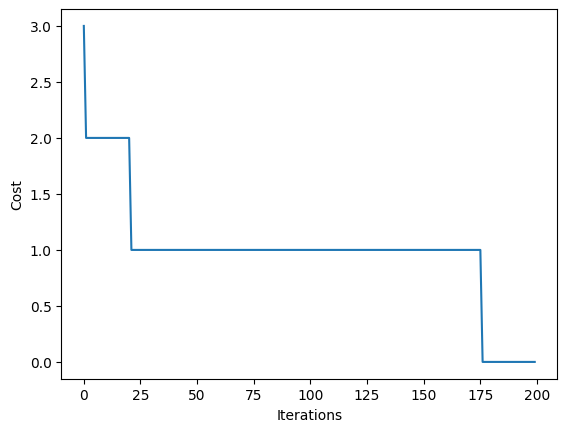

In [38]:
N = 7 # The number of queens

# Set bounds for each dimension (queen position)
x_max = np.array([N for _ in range(N)])
x_min = np.array([0 for _ in range(N)])
my_bounds = (x_min, x_max)

# Define PSO parameters
options = {'c1': 2, 'c2': 2, 'w': 0.5}
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=N, options=options, bounds=my_bounds)

# Optimize the objective function
start=time.time()
best_cost, best_position = optimizer.optimize(objective_function, iters=200)
end=time.time()
delta = end-start
print("Time: {:.2f} seconds".format(delta))
print("Time: {:.2f} minutes".format(delta/60))

# Print the best solution found
print("Best solution: ", best_position)
print([int(x) for x in best_position])
print("Best fitness: ", 0 if best_cost == 0 else best_cost)

# Plot the cost history
plt.plot(optimizer.cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

2023-04-01 20:24:57,900 - pyswarms.single.global_best - INFO - Optimize for 350 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|350/350, best_cost=0
2023-04-01 20:25:17,610 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [2.49784948 5.17655771 7.55791136 0.60462059 4.24908501 6.34570317
 1.14603049 3.6449037 ]


Time: 19.71 seconds
Time: 0.33 minutes
Best solution:  [2.49784948 5.17655771 7.55791136 0.60462059 4.24908501 6.34570317
 1.14603049 3.6449037 ]
[2, 5, 7, 0, 4, 6, 1, 3]
Best fitness:  0


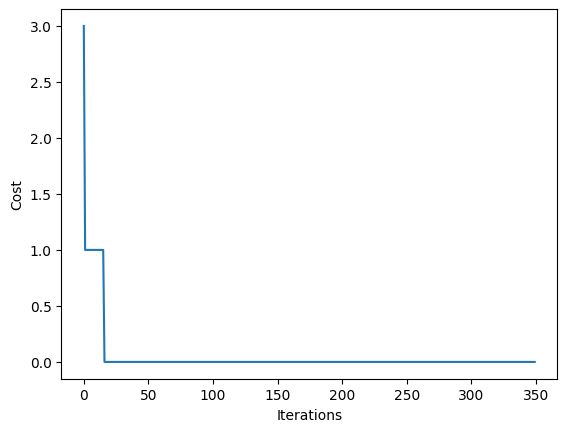

In [39]:
N = 8 # The number of queens

# Set bounds for each dimension (queen position)
x_max = np.array([N for _ in range(N)])
x_min = np.array([0 for _ in range(N)])
my_bounds = (x_min, x_max)

# Define PSO parameters
options = {'c1': 2, 'c2': 2, 'w': 0.5}
optimizer = ps.single.GlobalBestPSO(n_particles=300, dimensions=N, options=options, bounds=my_bounds)

# Optimize the objective function
start=time.time()
best_cost, best_position = optimizer.optimize(objective_function, iters=350)
end=time.time()
delta = end-start
print("Time: {:.2f} seconds".format(delta))
print("Time: {:.2f} minutes".format(delta/60))

# Print the best solution found
print("Best solution: ", best_position)
print([int(x) for x in best_position])
print("Best fitness: ", 0 if best_cost == 0 else best_cost)

# Plot the cost history
plt.plot(optimizer.cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

2023-04-01 20:32:17,959 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=0
2023-04-01 20:32:58,067 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [3.87037976 1.05611283 6.00553765 8.1786881  0.5194897  7.74584683
 4.510313   2.82725202 5.41636482]


Time: 40.11 seconds
Time: 0.67 minutes
Best solution:  [3.87037976 1.05611283 6.00553765 8.1786881  0.5194897  7.74584683
 4.510313   2.82725202 5.41636482]
[3, 1, 6, 8, 0, 7, 4, 2, 5]
Best fitness:  0


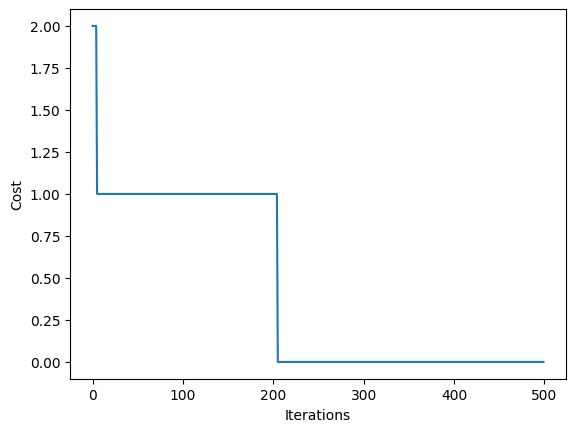

In [48]:
N = 9 # The number of queens

# Set bounds for each dimension (queen position)
x_max = np.array([N for _ in range(N)])
x_min = np.array([0 for _ in range(N)])
my_bounds = (x_min, x_max)

# Define PSO parameters
options = {'c1': 2, 'c2': 2, 'w': 0.5}
optimizer = ps.single.GlobalBestPSO(n_particles=400, dimensions=N, options=options, bounds=my_bounds)

# Optimize the objective function
start=time.time()
best_cost, best_position = optimizer.optimize(objective_function, iters=500)
end=time.time()
delta = end-start
print("Time: {:.2f} seconds".format(delta))
print("Time: {:.2f} minutes".format(delta/60))

# Print the best solution found
print("Best solution: ", best_position)
print([int(x) for x in best_position])
print("Best fitness: ", 0 if best_cost == 0 else best_cost)

# Plot the cost history
plt.plot(optimizer.cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

2023-04-02 10:40:56,507 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=1
2023-04-02 10:41:59,230 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0, best pos: [6.90407582 0.11856599 3.73790383 0.67623306 9.59239836 7.07487724
 4.56276492 2.92742301 8.41816684 5.14698148]


Time: 62.72 seconds
Time: 1.05 minutes
Best solution:  [6.90407582 0.11856599 3.73790383 0.67623306 9.59239836 7.07487724
 4.56276492 2.92742301 8.41816684 5.14698148]
[6, 0, 3, 0, 9, 7, 4, 2, 8, 5]
Best fitness:  1.0


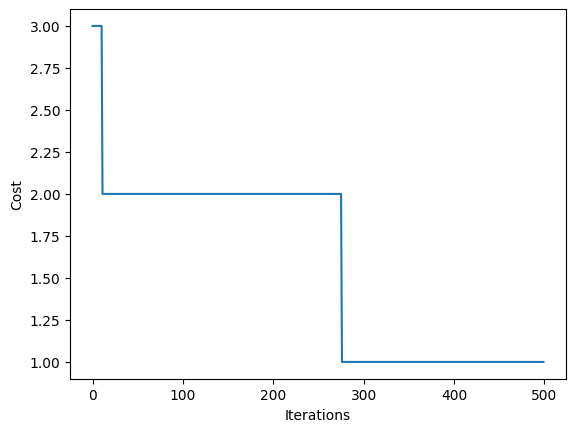

In [17]:
N = 10 # The number of queens

# Set bounds for each dimension (queen position)
x_max = np.array([N for _ in range(N)])
x_min = np.array([0 for _ in range(N)])
my_bounds = (x_min, x_max)

# Define PSO parameters
options = {'c1': 2, 'c2': 2, 'w': 0.5}
optimizer = ps.single.GlobalBestPSO(n_particles=500, dimensions=N, options=options, bounds=my_bounds)

# Optimize the objective function
start=time.time()
best_cost, best_position = optimizer.optimize(objective_function, iters=500)
end=time.time()
delta = end-start
print("Time: {:.2f} seconds".format(delta))
print("Time: {:.2f} minutes".format(delta/60))

# Print the best solution found
print("Best solution: ", best_position)
print([int(x) for x in best_position])
print("Best fitness: ", 0 if best_cost == 0 else best_cost)

# Plot the cost history
plt.plot(optimizer.cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

Niestety, PSO słabo radzi sobie z średnimi i wielkimi inputami.

2023-04-02 10:41:59,439 - pyswarms.single.global_best - INFO - Optimize for 800 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|800/800, best_cost=3
2023-04-02 10:44:16,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.0, best pos: [ 2.94814067 11.1150057   6.67436787 12.45897847  7.29396546  0.70294858
  0.69018922  3.65194502  8.66355033 10.76193819  9.84087281  9.24005605
  5.84081783  1.94273128  4.85448321]


Time: 136.62 seconds
Time: 2.28 minutes
Best solution:  [ 2.94814067 11.1150057   6.67436787 12.45897847  7.29396546  0.70294858
  0.69018922  3.65194502  8.66355033 10.76193819  9.84087281  9.24005605
  5.84081783  1.94273128  4.85448321]
[2, 11, 6, 12, 7, 0, 0, 3, 8, 10, 9, 9, 5, 1, 4]
Best fitness:  3.0


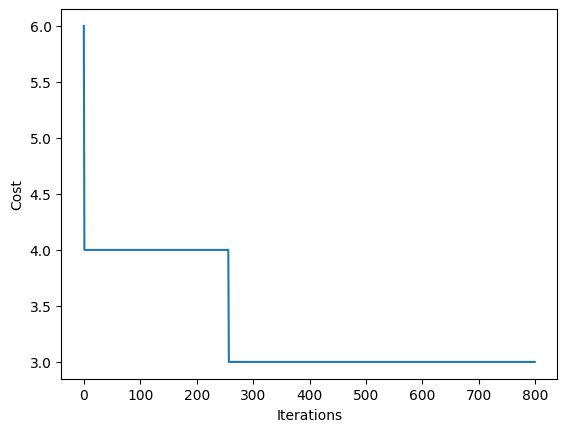

In [18]:
N = 15 # The number of queens

# Set bounds for each dimension (queen position)
x_max = np.array([N for _ in range(N)])
x_min = np.array([0 for _ in range(N)])
my_bounds = (x_min, x_max)

# Define PSO parameters
options = {'c1': 2, 'c2': 2, 'w': 0.5}
optimizer = ps.single.GlobalBestPSO(n_particles=500, dimensions=N, options=options, bounds=my_bounds)

# Optimize the objective function
start=time.time()
best_cost, best_position = optimizer.optimize(objective_function, iters=800)
end=time.time()
delta = end-start
print("Time: {:.2f} seconds".format(delta))
print("Time: {:.2f} minutes".format(delta/60))

# Print the best solution found
print("Best solution: ", best_position)
print([int(x) for x in best_position])
print("Best fitness: ", 0 if best_cost == 0 else best_cost)

# Plot the cost history
plt.plot(optimizer.cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

| N | Success Rate | Mean Time |    Particles    |      Iters       | Example Solution |
|:-:|:------------:|:---------:|:---------------:|:----------------:|:----------------:|
| 5 |     99%      |   0.14 s  |       20        |        50        | [3, 1, 4, 2, 0]  |
| 6 |     78%      |   0.57 s  |      200        |        100       |[1, 3, 5, 0, 2, 4]|
| 7 |     83%      |   0.24 s  |      200        |        100       |[1, 4, 2, 0, 6, 3, 5]|
| 8 |     71%      |   17.49 s |      300        |        350       |[5, 3, 0, 4, 7, 1, 6, 2]|
| 9 |     53%      |   35.69 s |      400        |        500       |[0, 4, 6, 8, 2, 7, 1, 3, 5]|
| 10|     16%      |   51.65 s |      500        |        500        |[8, 2, 4, 1, 7, 9, 6, 3, 5, 0]|

Zmiana wykonywania czasu algorytmu w zależności od n. 

![zmiana wykonywania czasu algorytmu (w sekundach) w zależności od n](n-time2.png)

Czas rośnie gwałtownie. Porównując czas z algorytmem AG należy pamiętać, że PSO nie przerywa iteracji, gdy znajdzie rozwiązanie.

Zmiana współczynnika osiągnięcia sukcesu przez algorytm PSO w zależności od n.

![zmiana współczynnika sukcesu algorytmu w zależności od n](n-success.png)

Niestety wraz ze wzrostem wielkości szachownicy/planszy szybko maleje prawdopodobieństwo odnalezienia rozwiązania w różnych wariantach.

Algorytm PSO zaimplementowany w bibliotece pyswarms może być dobrym wyborem jedynie dla małych problemów (szachownicy n-queens), np. dla plansz o rozmiarze 5x5 lub 6x6, gdzie poszukiwana przestrzeń jest mniejsza, a liczba rozwiązań jest ograniczona. Jednak dla średnich plansz, takich jak 10x10 lub większych, operowanie na liczbach zmiennoprzecinkowych i brak gradientu w funkcji celu, może utrudniać skuteczne odnajdywanie globalnego optimum, a zamiast tego algorytm może utknąć w lokalnym maksimum.
Znalezienie optymalnego rozwiązania dla problemu o dużym rozmiarze w tym przypadku, wymaga znacznego nakładu czasu i zasobów obliczeniowych.

Warto również zauważyć, że mimo istnienia źródeł z rekomendacjami, metoda prób i błędów wciąż pozostaje jednym z najskuteczniejszych narzędzi doboru optymalnych parametrów dla algorytmów genetycznych i optymalizacji roju cząstek. Często zdarza się, że rekomendowane ustawienia nie sprawdzają się, nie przynoszą oczekiwanych wyników, co tylko potwierdza przewagę podejścia opartego na eksperymentowaniu z różnymi kombinacjami parametrów.

Dla każdego przypadku AG radzi sobie z większą skutecznością i szybciej od PSO.

Algorytm genetyczny (AG) jest górującym wyborem dla problemu n-queens, ponieważ pozwala na operowanie na chromosomach i wykonanie mutacji, co umożliwia eksplorowanie większej liczby rozwiązań w przeszukiwanej przestrzeni. Ponadto, w przypadku większych plansz, AG lepiej radzi sobie z optymalizacją funkcji celu niż PSO, ponieważ działa na poziomie chromosomów - zbioru genów liczb całkowitych, a nie na poziomie liczb 
zmiennoprzecinkowych.



Bibliografia:
- Complexity of n-Queens Completion (Extended Abstract), Ian P. Gent, Christopher Jefferson, Peter Nightingale
- https://optimization.cbe.cornell.edu/index.php?title=Heuristic_algorithms
- An Adaptive Genetic Algorithm for Solving NQueens Problem, Uddalok Sarkar, Sayan Nag
- https://blog.derlin.ch/genetic-algorithms-with-pygad#heading-steady-state-selection-sss-default
- Particle Swarm Optimization For N-Queens Problem, Aftab Ahmed, Attique Shah, Kamran Ali Sani and Abdul Hussain Shah Bukhari
- https://towardsai.net/p/computer-science/solving-the-5-queens-problem-using-genetic-algorithm
- canva: @ratiodesign